In [12]:
import streamlit as st
import fitz  # pymupdf
import faiss
import numpy as np
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from typing import TypedDict, List, Dict, Any
import pickle
import os
import tempfile
from dotenv import load_dotenv
import time


In [13]:
st.set_page_config(
    page_title="PDF 분석 AI 어시스턴트",
    page_icon="🤖",
    layout="wide",
    initial_sidebar_state="expanded"
)

2025-06-20 14:11:28.085 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [14]:
load_dotenv()

True

In [15]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o', streaming=True)

In [16]:
def init_session_state():
    """세션 상태 안전하게 초기화"""
    if 'chunks' not in st.session_state:
        st.session_state.chunks = []
    if 'index' not in st.session_state:
        st.session_state.index = None
    if 'embedding_model' not in st.session_state:
        st.session_state.embedding_model = None
    if 'metadatas' not in st.session_state:
        st.session_state.metadatas = []
    if 'file_processed' not in st.session_state:
        st.session_state.file_processed = False
    if 'chat_history' not in st.session_state:
        st.session_state.chat_history = []
    if 'agent_graph' not in st.session_state:
        st.session_state.agent_graph = None
    if 'uploaded_filename' not in st.session_state:
        st.session_state.uploaded_filename = ""


In [17]:
init_session_state()


2025-06-20 14:11:28.710 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 14:11:28.710 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 14:11:28.710 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 14:11:28.711 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 14:11:28.711 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-20 14:11:28.711 WARNING streamlit.run

In [18]:
class AgentState(TypedDict):
    messages: List[Any]


In [ ]:
# ============== PDF 분석 Streamlit 앱 ==============
import streamlit as st
import fitz  # pymupdf
import faiss
import numpy as np
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode
from typing import TypedDict, List, Dict, Any
import pickle
import os
import tempfile
from dotenv import load_dotenv
import time

# 페이지 설정
st.set_page_config(
    page_title="파일 분석 AI 어시스턴트",
    page_icon="🤖",
    layout="wide",
    initial_sidebar_state="expanded"
)

# 환경 설정
load_dotenv()

# ============== 세션 상태 초기화 ==============
def init_session_state():
    """세션 상태 안전하게 초기화"""
    if 'chunks' not in st.session_state:
        st.session_state.chunks = []
    if 'index' not in st.session_state:
        st.session_state.index = None
    if 'embedding_model' not in st.session_state:
        st.session_state.embedding_model = None
    if 'metadatas' not in st.session_state:
        st.session_state.metadatas = []
    if 'file_processed' not in st.session_state:
        st.session_state.file_processed = False
    if 'chat_history' not in st.session_state:
        st.session_state.chat_history = []
    if 'agent_graph' not in st.session_state:
        st.session_state.agent_graph = None
    if 'uploaded_filename' not in st.session_state:
        st.session_state.uploaded_filename = ""
    if 'file_metadata' not in st.session_state:
        st.session_state.file_metadata = {}
    if 'pdf_metadata' not in st.session_state:
        st.session_state.pdf_metadata = {}
    if 'current_input' not in st.session_state:
        st.session_state.current_input = ""
    if 'processing' not in st.session_state:
        st.session_state.processing = False

# 초기화 실행
init_session_state()

# ============== 타입 정의 ==============
class AgentState(TypedDict):
    messages: List[Any]

# ============== 파일 처리 함수들 ==============

def extract_text_from_file(uploaded_file):
    """다양한 파일 형식에서 텍스트 추출"""
    file_type = uploaded_file.type
    file_name = uploaded_file.name.lower()
    
    # 기본 파일 정보 저장
    st.session_state.file_metadata = {
        'filename': uploaded_file.name,
        'file_type': file_type,
        'file_size': uploaded_file.size,
        'file_size_mb': round(uploaded_file.size / (1024*1024), 2)
    }
    
    try:
        if file_type == "application/pdf" or file_name.endswith('.pdf'):
            return extract_text_with_fitz(uploaded_file)
        
        elif file_type == "text/plain" or file_name.endswith(('.txt', '.md', '.py', '.js', '.html', '.css', '.json', '.xml', '.csv')):
            # 텍스트 파일 처리
            content = uploaded_file.read()
            if isinstance(content, bytes):
                # 다양한 인코딩 시도
                for encoding in ['utf-8', 'cp949', 'euc-kr', 'latin-1']:
                    try:
                        text = content.decode(encoding)
                        st.success(f"✅ 텍스트 파일 읽기 완료! ({encoding} 인코딩)")
                        
                        # 텍스트 파일 상세 메타데이터 추가
                        lines = text.split('\n')
                        words = text.split()
                        
                        # 파일 확장자로 파일 유형 판단
                        file_ext = file_name.split('.')[-1] if '.' in file_name else 'txt'
                        file_type_name = {
                            'py': 'Python 코드',
                            'js': 'JavaScript 코드', 
                            'html': 'HTML 문서',
                            'css': 'CSS 스타일시트',
                            'json': 'JSON 데이터',
                            'xml': 'XML 문서',
                            'csv': 'CSV 데이터',
                            'md': 'Markdown 문서',
                            'txt': '텍스트 문서'
                        }.get(file_ext, '텍스트 파일')
                        
                        st.session_state.file_metadata.update({
                            'encoding': encoding,
                            'lines': len(lines),
                            'words': len(words),
                            'characters': len(text),
                            'file_type_name': file_type_name,
                            'extension': file_ext.upper(),
                            'paragraphs': len([line for line in lines if line.strip()]),
                            'empty_lines': len([line for line in lines if not line.strip()])
                        })
                        
                        return text
                    except UnicodeDecodeError:
                        continue
                st.error("❌ 텍스트 파일 인코딩을 인식할 수 없습니다.")
                return ""
            else:
                return str(content)
        
        else:
            st.error(f"❌ 지원하지 않는 파일 형식입니다: {file_type}")
            return ""
            
    except Exception as e:
        st.error(f"❌ 파일 처리 중 오류: {e}")
        return ""

def extract_text_with_fitz(pdf_file):
    """PyMuPDF로 PDF 텍스트 추출"""
    try:
        # 임시 파일로 저장
        with tempfile.NamedTemporaryFile(delete=False, suffix='.pdf') as tmp_file:
            tmp_file.write(pdf_file.read())
            tmp_path = tmp_file.name
        
        doc = fitz.open(tmp_path)
        
        # PDF 메타데이터 추출
        metadata = doc.metadata
        st.session_state.pdf_metadata = {
            'title': metadata.get('title', '제목 없음'),
            'author': metadata.get('author', '작성자 없음'),
            'subject': metadata.get('subject', '주제 없음'),
            'creator': metadata.get('creator', '생성 프로그램 없음'),
            'producer': metadata.get('producer', '제작 프로그램 없음'),
            'creationDate': metadata.get('creationDate', '생성일 없음'),
            'modDate': metadata.get('modDate', '수정일 없음'),
            'total_pages': len(doc)
        }
        
        # 진행 상황 표시
        progress_bar = st.progress(0)
        status_text = st.empty()
        
        full_text = ""
        total_pages = len(doc)
        
        for page_num in range(total_pages):
            progress = (page_num + 1) / total_pages
            progress_bar.progress(progress)
            status_text.text(f"페이지 {page_num + 1}/{total_pages} 처리 중...")
            
            page = doc[page_num]
            text = page.get_text()
            
            if text and text.strip():
                text = text.replace('\x00', '')
                text = text.replace('\ufeff', '')
                text = text.replace('\r\n', '\n')
                text = text.replace('\r', '\n')
                full_text += text + "\n\n"
        
        doc.close()
        os.unlink(tmp_path)  # 임시 파일 삭제
        
        progress_bar.progress(1.0)
        status_text.text(f"✅ PDF 텍스트 추출 완료! 총 {len(full_text)} 글자")
        time.sleep(1)
        progress_bar.empty()
        status_text.empty()
        
        return full_text
        
    except Exception as e:
        st.error(f"❌ PDF 텍스트 추출 오류: {e}")
        return ""

def chunk_text(text, chunk_size=2000, overlap=100):
    """텍스트를 청크로 나누는 함수"""
    if not text.strip():
        return []
    
    chunks = []
    start = 0
    
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end].strip()
        
        if chunk:
            chunks.append(chunk)
        
        start = end - overlap
    
    return chunks

def create_vectorstore(chunks):
    """FAISS 벡터 스토어 생성"""
    if not chunks:
        return None, None, None
    
    try:
        with st.spinner('🔄 임베딩 생성 중... (시간이 걸릴 수 있습니다)'):
            embedding_model = OpenAIEmbeddings(model='text-embedding-3-large')
            embeddings = embedding_model.embed_documents(chunks)
            embeddings = np.array(embeddings).astype('float32')
            
            # FAISS 인덱스 생성
            dimension = embeddings.shape[1]
            index = faiss.IndexFlatL2(dimension)
            index.add(embeddings)
            
            # 메타데이터 생성
            metadatas = []
            for i, chunk in enumerate(chunks):
                metadatas.append({
                    'chunk_id': i,
                    'chunk_size': len(chunk),
                    'preview': chunk[:100] + "..." if len(chunk) > 100 else chunk
                })
        
        st.success(f"✅ 벡터 스토어 생성 완료! {index.ntotal}개 벡터 저장")
        return index, embedding_model, metadatas
        
    except Exception as e:
        st.error(f"❌ 벡터 스토어 생성 오류: {e}")
        return None, None, None

def safe_search_documents(query, k=3):
    """안전한 문서 검색"""
    try:
        if (not hasattr(st.session_state, 'index') or 
            st.session_state.index is None or 
            not hasattr(st.session_state, 'embedding_model') or
            st.session_state.embedding_model is None):
            return []
        
        query_embedding = st.session_state.embedding_model.embed_query(query)
        query_embedding = np.array([query_embedding]).astype('float32')
        
        distances, indices = st.session_state.index.search(query_embedding, k)
        
        results = []
        for i, (distance, idx) in enumerate(zip(distances[0], indices[0])):
            if idx < len(st.session_state.chunks):
                results.append({
                    'chunk_id': idx,
                    'content': st.session_state.chunks[idx],
                    'score': 1.0 - (distance / 2.0),
                    'metadata': st.session_state.metadatas[idx] if idx < len(st.session_state.metadatas) else {}
                })
        
        return results
        
    except Exception as e:
        st.error(f"검색 오류: {e}")
        return []

# ============== LangGraph Tools ==============

@tool
def search_uploaded_documents(query: str) -> str:
    """업로드된 파일에서 내용을 검색합니다."""
    try:
        if not hasattr(st.session_state, 'file_processed') or not st.session_state.file_processed:
            return "업로드된 파일이 없습니다. 먼저 파일을 업로드하고 처리해주세요."
        
        results = safe_search_documents(query, 3)
        
        if not results:
            return f"'{query}'에 대한 검색 결과가 없습니다."
        
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"[검색결과 {i}] (유사도: {result['score']:.3f})\n"
                f"{result['content'][:400]}{'...' if len(result['content']) > 400 else ''}\n"
            )
        
        return "\n".join(formatted_results)
        
    except Exception as e:
        return f"파일 검색 중 오류: {str(e)}"

@tool
def web_search_tool(query: str) -> str:
    """웹에서 최신 정보를 검색합니다."""
    try:
        from langchain_community.tools import DuckDuckGoSearchRun
        search_tool = DuckDuckGoSearchRun()
        results = search_tool.run(query)
        return f"🌐 웹 검색 결과:\n\n{results}"
    except ImportError:
        return f"""🔍 "{query}" 검색 링크:
• Google: https://www.google.com/search?q={query.replace(' ', '+')}
• 네이버: https://search.naver.com/search.naver?query={query.replace(' ', '+')}

실시간 웹 검색: pip install duckduckgo-search"""
    except Exception as e:
        return f"웹 검색 중 오류: {str(e)}"

@tool
def general_chat_tool(question: str) -> str:
    """일반적인 질문에 답변합니다."""
    try:
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
        response = llm.invoke([HumanMessage(content=question)])
        return response.content
    except Exception as e:
        return f"일반 질문 처리 중 오류: {str(e)}"

@tool
def summarize_content_tool() -> str:
    """업로드된 파일의 내용을 요약합니다."""
    try:
        if (not hasattr(st.session_state, 'file_processed') or 
            not st.session_state.file_processed or
            not hasattr(st.session_state, 'chunks') or
            not st.session_state.chunks):
            return "요약할 파일이 없습니다. 먼저 파일을 업로드하고 처리해주세요."
        
        # 처음 5개 청크를 요약 (더 많은 내용)
        content = "\n".join(st.session_state.chunks[:5])
        
        if not content.strip():
            return "요약할 내용이 없습니다."
        
        # 내용이 너무 길면 잘라서 처리
        if len(content) > 8000:
            content = content[:8000] + "..."
        
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
        
        # 간단한 요약 프롬프트
        prompt = f"""다음 내용을 한국어로 간단하고 명확하게 요약해주세요:

{content}

요약:"""
        
        response = llm.invoke([HumanMessage(content=prompt)])
        return response.content
        
    except Exception as e:
        return f"요약 중 오류가 발생했습니다: {str(e)}"

@tool
def get_document_info_tool() -> str:
    """현재 로드된 파일의 정보를 반환합니다."""
    try:
        if not hasattr(st.session_state, 'file_processed') or not st.session_state.file_processed:
            return "로드된 파일이 없습니다. 파일을 먼저 업로드하고 처리해주세요."
        
        if not hasattr(st.session_state, 'chunks') or not st.session_state.chunks:
            return "파일 처리 정보가 없습니다."
        
        # 기본 통계 정보
        total_chars = sum(len(chunk) for chunk in st.session_state.chunks)
        filename = getattr(st.session_state, 'uploaded_filename', '알 수 없음')
        
        # 파일 메타데이터 가져오기
        file_meta = getattr(st.session_state, 'file_metadata', {})
        pdf_meta = getattr(st.session_state, 'pdf_metadata', {})
        
        info_text = f"""📄 **파일 정보**
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📁 **기본 정보**
• 파일명: {filename}
• 파일 형식: {file_meta.get('file_type', '알 수 없음')}
• 파일 크기: {file_meta.get('file_size_mb', 0)} MB ({file_meta.get('file_size', 0):,} bytes)
"""

        # PDF 메타데이터가 있는 경우
        if pdf_meta:
            info_text += f"""
📖 **PDF 문서 정보**
• 제목: {pdf_meta.get('title', '제목 없음')}
• 작성자: {pdf_meta.get('author', '작성자 없음')}
• 주제: {pdf_meta.get('subject', '주제 없음')}
• 총 페이지 수: {pdf_meta.get('total_pages', '알 수 없음')}페이지
• 생성 프로그램: {pdf_meta.get('creator', '알 수 없음')}
• 제작 프로그램: {pdf_meta.get('producer', '알 수 없음')}
• 생성일: {pdf_meta.get('creationDate', '알 수 없음')}
• 수정일: {pdf_meta.get('modDate', '알 수 없음')}
"""

        # 텍스트 파일 메타데이터가 있는 경우
        if 'lines' in file_meta:
            info_text += f"""
📝 **{file_meta.get('file_type_name', '텍스트 파일')} 정보**
• 파일 형식: {file_meta.get('extension', 'TXT')} 파일
• 인코딩: {file_meta.get('encoding', '알 수 없음')}
• 총 줄 수: {file_meta.get('lines', 0):,}줄
• 총 단어 수: {file_meta.get('words', 0):,}개
• 총 문자 수: {file_meta.get('characters', 0):,}자
• 내용이 있는 줄: {file_meta.get('paragraphs', 0):,}줄
• 빈 줄: {file_meta.get('empty_lines', 0):,}줄
"""

        info_text += f"""
🔧 **분석 정보**
• 청크 수: {len(st.session_state.chunks):,}개
• 총 텍스트 길이: {total_chars:,}자
• 평균 청크 크기: {total_chars // len(st.session_state.chunks):,}자

🛠️ **사용 가능한 기능**
• 📝 파일 내용 요약
• 🔍 키워드/내용 검색  
• 🌐 웹 검색과 비교
• 💬 파일 관련 질의응답

💡 **예시 질문**
• "이 문서의 핵심 내용을 요약해줘"
• "특정 키워드를 검색해줘"
• "문서에서 중요한 부분을 찾아줘"
"""

        return info_text
    
    except Exception as e:
        return f"파일 정보 조회 중 오류: {str(e)}"

# ============== LangGraph 그래프 ==============

def should_continue(state: AgentState) -> str:
    """다음 단계를 결정하는 함수 - tool calling 제거로 항상 END"""
    return END

def agent(state: AgentState) -> AgentState:
    """LLM 에이전트 함수 - 키워드 기반 라우팅으로 tool calling 에러 방지"""
    messages = state["messages"]
    
    # 메시지가 비어있으면 기본 응답
    if not messages:
        return {"messages": [AIMessage(content="안녕하세요! 무엇을 도와드릴까요?")]}
    
    # 마지막 사용자 메시지 가져오기
    user_message = ""
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            user_message = msg.content
            break
    
    if not user_message:
        return {"messages": messages + [AIMessage(content="질문을 입력해주세요.")]}
    
    try:
        # 키워드 기반 라우팅으로 tool calling 대신 직접 함수 호출
        user_lower = user_message.lower()
        
        # 파일 관련 키워드
        file_keywords = ['파일', '문서', '요약', '정보', '내용', '분석']
        web_keywords = ['검색', '뉴스', '최신', '날씨', '현재', '찾아']
        
        response_content = ""
        
        # 파일이 업로드된 상태에서 파일 관련 질문
        if st.session_state.file_processed and any(keyword in user_lower for keyword in file_keywords):
            if '요약' in user_lower:
                # 파일 요약
                try:
                    if st.session_state.chunks:
                        content = "\n".join(st.session_state.chunks[:5])
                        if len(content) > 8000:
                            content = content[:8000] + "..."
                        
                        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
                        prompt = f"다음 내용을 한국어로 간단하고 명확하게 요약해주세요:\n\n{content}\n\n요약:"
                        response = llm.invoke([HumanMessage(content=prompt)])
                        response_content = response.content
                    else:
                        response_content = "요약할 파일 내용이 없습니다."
                except Exception as e:
                    response_content = f"요약 중 오류가 발생했습니다: {str(e)}"
                    
            elif '정보' in user_lower:
                # 파일 정보
                response_content = get_document_info_tool_direct()
                
            else:
                # 파일 검색
                try:
                    results = safe_search_documents(user_message, 3)
                    if results:
                        formatted_results = []
                        for i, result in enumerate(results, 1):
                            formatted_results.append(
                                f"[검색결과 {i}] (유사도: {result['score']:.3f})\n"
                                f"{result['content'][:400]}{'...' if len(result['content']) > 400 else ''}\n"
                            )
                        response_content = "\n".join(formatted_results)
                    else:
                        response_content = f"'{user_message}'에 대한 검색 결과가 없습니다."
                except Exception as e:
                    response_content = f"검색 중 오류: {str(e)}"
        
        # 웹 검색이 필요한 질문
        elif any(keyword in user_lower for keyword in web_keywords):
            try:
                from langchain_community.tools import DuckDuckGoSearchRun
                search_tool = DuckDuckGoSearchRun()
                results = search_tool.run(user_message)
                response_content = f"🌐 웹 검색 결과:\n\n{results}"
            except ImportError:
                response_content = f"""🔍 "{user_message}" 검색 링크:
• Google: https://www.google.com/search?q={user_message.replace(' ', '+')}
• 네이버: https://search.naver.com/search.naver?query={user_message.replace(' ', '+')}

실시간 웹 검색: pip install duckduckgo-search"""
            except Exception as e:
                response_content = f"웹 검색 중 오류: {str(e)}"
        
        # 일반 질문
        else:
            try:
                llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
                response = llm.invoke([HumanMessage(content=user_message)])
                response_content = response.content
            except Exception as e:
                response_content = f"일반 질문 처리 중 오류: {str(e)}"
        
        # AI 응답 생성
        ai_response = AIMessage(content=response_content)
        return {"messages": messages + [ai_response]}
        
    except Exception as e:
        error_response = AIMessage(content=f"처리 중 오류가 발생했습니다: {str(e)}")
        return {"messages": messages + [error_response]}

# 그래프 빌더 생성 (tool calling 제거)
graph_builder = StateGraph(AgentState)
graph_builder.add_node('agent', agent)

graph_builder.add_edge(START, 'agent')
graph_builder.add_edge('agent', END)

# 그래프 컴파일
graph = graph_builder.compile()

# ============== 사용자 입력 처리 함수 ==============

def process_user_input():
    """사용자 입력 처리 함수 - 중복 실행 방지"""
    # 처리 중이면 무시
    if st.session_state.processing:
        return
    
    user_input = st.session_state.current_input.strip()
    if not user_input:
        return
    
    # 처리 상태 설정
    st.session_state.processing = True
    
    try:
        # 사용자 메시지 추가
        st.session_state.chat_history.append(("user", user_input))
        
        # AI 응답 생성
        if st.session_state.agent_graph is None:
            st.session_state.agent_graph = graph
        
        # 새로운 대화 시작 (이전 메시지 체인 문제 방지)
        initial_state = {"messages": [HumanMessage(content=user_input)]}
        result = st.session_state.agent_graph.invoke(initial_state)
        
        # 응답 추출 (마지막 AI 메시지 찾기)
        ai_response = None
        if result and "messages" in result:
            # 역순으로 검색하여 첫 번째 AI 메시지 찾기
            for msg in reversed(result["messages"]):
                if isinstance(msg, AIMessage):
                    ai_response = msg.content
                    break
        
        if ai_response:
            response = ai_response
        else:
            response = "응답을 생성할 수 없습니다."
        
        # 채팅 히스토리에 추가
        st.session_state.chat_history.append(("assistant", response))
        
    except Exception as e:
        error_msg = f"죄송합니다. 처리 중 오류가 발생했습니다: {str(e)}"
        st.session_state.chat_history.append(("assistant", error_msg))
    
    finally:
        # 입력창 초기화 및 처리 상태 해제
        st.session_state.current_input = ""
        st.session_state.processing = False

# ============== 빠른 버튼 처리 함수들 ==============

def handle_quick_summary():
    """파일 요약 빠른 버튼 처리"""
    if st.session_state.processing:
        return
    
    st.session_state.processing = True
    try:
        response = summarize_content_tool_direct()
        st.session_state.chat_history.append(("user", "이 파일을 요약해줘"))
        st.session_state.chat_history.append(("assistant", response))
    except Exception as e:
        st.error(f"요약 중 오류: {e}")
    finally:
        st.session_state.processing = False

def handle_quick_info():
    """파일 정보 빠른 버튼 처리"""
    if st.session_state.processing:
        return
    
    st.session_state.processing = True
    try:
        response = get_document_info_tool_direct()
        st.session_state.chat_history.append(("user", "파일 정보를 알려줘"))
        st.session_state.chat_history.append(("assistant", response))
    except Exception as e:
        st.error(f"정보 조회 중 오류: {e}")
    finally:
        st.session_state.processing = False

def handle_quick_search():
    """키워드 검색 빠른 버튼 처리"""
    if st.session_state.processing:
        return
    
    st.session_state.processing = True
    try:
        response = search_uploaded_documents_direct("중요한 키워드")
        st.session_state.chat_history.append(("user", "파일에서 중요한 키워드를 찾아줘"))
        st.session_state.chat_history.append(("assistant", response))
    except Exception as e:
        st.error(f"검색 중 오류: {e}")
    finally:
        st.session_state.processing = False

def handle_quick_file_search():
    """파일 내 검색 빠른 버튼 처리"""
    if st.session_state.processing:
        return
    
    st.session_state.processing = True
    try:
        response = "어떤 내용을 검색하고 싶으신가요? 구체적인 키워드나 질문을 입력해주세요."
        st.session_state.chat_history.append(("user", "파일에서 특정 내용을 검색하고 싶어"))
        st.session_state.chat_history.append(("assistant", response))
    except Exception as e:
        st.error(f"검색 중 오류: {e}")
    finally:
        st.session_state.processing = False

def handle_quick_python():
    """파이썬 질문 빠른 버튼 처리"""
    if st.session_state.processing:
        return
    
    st.session_state.processing = True
    try:
        response = general_chat_tool_direct("파이썬에서 리스트와 튜플의 차이점은?")
        st.session_state.chat_history.append(("user", "파이썬에서 리스트와 튜플의 차이점은?"))
        st.session_state.chat_history.append(("assistant", response))
    except Exception as e:
        st.error(f"답변 생성 중 오류: {e}")
    finally:
        st.session_state.processing = False

def handle_quick_web_search():
    """웹 검색 빠른 버튼 처리"""
    if st.session_state.processing:
        return
    
    st.session_state.processing = True
    try:
        response = web_search_tool_direct("최신 AI 뉴스")
        st.session_state.chat_history.append(("user", "최신 AI 뉴스를 검색해줘"))
        st.session_state.chat_history.append(("assistant", response))
    except Exception as e:
        st.error(f"검색 중 오류: {e}")
    finally:
        st.session_state.processing = False

def handle_quick_ai_question():
    """AI 질문 빠른 버튼 처리"""
    if st.session_state.processing:
        return
    
    st.session_state.processing = True
    try:
        response = general_chat_tool_direct("ChatGPT와 Claude의 차이점은?")
        st.session_state.chat_history.append(("user", "ChatGPT와 Claude의 차이점은?"))
        st.session_state.chat_history.append(("assistant", response))
    except Exception as e:
        st.error(f"답변 생성 중 오류: {e}")
    finally:
        st.session_state.processing = False

def handle_quick_coding():
    """코딩 질문 빠른 버튼 처리"""
    if st.session_state.processing:
        return
    
    st.session_state.processing = True
    try:
        response = general_chat_tool_direct("파이썬 클래스와 객체의 차이점을 설명해줘")
        st.session_state.chat_history.append(("user", "파이썬 클래스와 객체의 차이점을 설명해줘"))
        st.session_state.chat_history.append(("assistant", response))
    except Exception as e:
        st.error(f"답변 생성 중 오류: {e}")
    finally:
        st.session_state.processing = False

# ============== Streamlit UI ==============

def main():
    st.title("🤖 파일 분석 AI 어시스턴트")
    st.markdown("---")
    
    # API 키 체크
    if not os.getenv('OPENAI_API_KEY'):
        st.error("⚠️ OpenAI API 키가 설정되지 않았습니다. .env 파일을 확인해주세요.")
        st.stop()
    
    # 사이드바
    with st.sidebar:
        st.header("📄 파일 업로드")
        
        # 파일 업로드
        uploaded_file = st.file_uploader(
            "파일을 선택하세요",
            type=['pdf', 'txt', 'md', 'py', 'js', 'html', 'css', 'json', 'xml', 'csv'],
            help="PDF, 텍스트 파일, 코드 파일 등을 업로드할 수 있습니다."
        )
        
        if uploaded_file is not None:
            st.info(f"📁 선택된 파일: {uploaded_file.name}")
            st.info(f"📏 파일 크기: {uploaded_file.size:,} bytes")
            
            if st.button("📊 파일 분석 시작", type="primary"):
                with st.spinner("파일을 분석하는 중입니다..."):
                    try:
                        # 텍스트 추출
                        full_text = extract_text_from_file(uploaded_file)
                        
                        if full_text:
                            # 청킹
                            st.session_state.chunks = chunk_text(full_text)
                            st.info(f"✅ 청킹 완료! 총 {len(st.session_state.chunks)}개 청크 생성")
                            
                            # 벡터 스토어 생성
                            index, embedding_model, metadatas = create_vectorstore(st.session_state.chunks)
                            
                            if index is not None:
                                st.session_state.index = index
                                st.session_state.embedding_model = embedding_model
                                st.session_state.metadatas = metadatas
                                st.session_state.file_processed = True
                                st.session_state.uploaded_filename = uploaded_file.name
                                
                                st.success("🎉 파일 분석이 완료되었습니다!")
                                st.balloons()
                    except Exception as e:
                        st.error(f"파일 처리 중 오류: {e}")
        
        # 문서 정보 표시
        if st.session_state.file_processed:
            st.markdown("---")
            st.header("📊 파일 정보")
            
            if hasattr(st.session_state, 'uploaded_filename'):
                st.info(f"📁 파일명: {st.session_state.uploaded_filename}")
            
            if st.session_state.chunks:
                total_chars = sum(len(chunk) for chunk in st.session_state.chunks)
                
                col1, col2 = st.columns(2)
                with col1:
                    st.metric("청크 수", len(st.session_state.chunks))
                with col2:
                    st.metric("총 글자 수", f"{total_chars:,}")
            
            # 초기화 버튼
            if st.button("🔄 초기화", help="업로드된 파일을 초기화합니다"):
                for key in ['chunks', 'index', 'embedding_model', 'metadatas', 'file_processed', 'chat_history', 'uploaded_filename', 'file_metadata', 'pdf_metadata', 'current_input', 'processing']:
                    if key in st.session_state:
                        del st.session_state[key]
                st.rerun()
    
    # 메인 콘텐츠 - 항상 채팅 인터페이스 표시
    st.header("💬 AI 어시스턴트와 대화하기")
    
    if not st.session_state.file_processed:
        st.info("💡 일반 질문도 가능하고, 파일을 업로드하면 파일 분석도 할 수 있어요!")
        
        # 사용법 안내
        with st.expander("📖 사용법 안내", expanded=False):
            st.markdown("""
            ### 🚀 두 가지 사용 방법
            
            #### 1️⃣ 일반 AI 어시스턴트로 사용
            - 바로 아래에서 질문하세요!
            - 웹 검색, 일반 지식 질문 등 모든 질문 가능
            
            #### 2️⃣ 파일 분석 (다양한 형식 지원)
            1. **파일 업로드**: 왼쪽 사이드바에서 파일을 업로드하세요
               - 📄 **PDF**: 문서, 논문, 보고서 등
               - 📝 **텍스트**: .txt, .md 파일
               - 💻 **코드**: .py, .js, .html, .css, .json 등
               - 📊 **데이터**: .csv, .xml 등
            2. **분석 시작**: "파일 분석 시작" 버튼을 클릭하세요
            3. **파일 질문**: 업로드한 파일에 대해 질문할 수 있습니다
            
            ### 💡 예시 질문
            **일반 질문:**
            - "파이썬에서 리스트와 튜플의 차이점은?"
            - "오늘 날씨는 어때?"
            - "최신 AI 뉴스를 검색해줘"
            
            **파일 질문 (업로드 후):**
            - "이 파일의 주요 내용을 요약해줘"
            - "코드에서 함수들을 설명해줘"
            - "파일에서 중요한 키워드를 찾아줘"
            - "이 데이터의 패턴을 분석해줘"
            """)
    
    # 에이전트 그래프 초기화 (모든 tool 함수가 정의된 후에 실행)
    try:
        if st.session_state.agent_graph is None:
            st.session_state.agent_graph = graph
    except Exception as e:
        st.error(f"AI 초기화 중 오류: {e}")
        st.info("페이지를 새로고침해주세요.")
    
    # 채팅 히스토리 표시
    chat_container = st.container()
    
    with chat_container:
        for i, (role, message) in enumerate(st.session_state.chat_history):
            if role == "user":
                with st.chat_message("user"):
                    st.write(message)
            else:
                with st.chat_message("assistant"):
                    st.write(message)
    
    # 사용자 입력 (항상 맨 아래에 고정)
    st.markdown("---")
    st.subheader("✍️ 질문하기")
    
    # 텍스트 입력과 버튼을 같은 행에 배치
    col1, col2 = st.columns([4, 1])
    
    with col1:
        # on_change 콜백을 사용하여 엔터키 처리
        user_input = st.text_input(
            "질문을 입력하세요",
            value=st.session_state.current_input,
            placeholder="예: '파이썬이란?' 또는 '파일을 요약해줘' (Enter 또는 전송 버튼)",
            key="text_input",
            on_change=process_user_input
        )
        # 입력값을 세션 상태에 동기화
        st.session_state.current_input = user_input
    
    with col2:
        # 전송 버튼 클릭 처리
        if st.button("전송", type="primary", use_container_width=True):
            process_user_input()
            st.rerun()
    
    # 빠른 질문 버튼들
    st.markdown("---")
    
    if st.session_state.file_processed:
        st.subheader("🎯 파일 관련 빠른 질문")
        col1, col2, col3, col4 = st.columns(4)
        
        with col1:
            if st.button("📝 파일 요약", on_click=handle_quick_summary):
                st.rerun()
        
        with col2:
            if st.button("📊 파일 정보", on_click=handle_quick_info):
                st.rerun()
        
        with col3:
            if st.button("🔍 키워드 검색", on_click=handle_quick_search):
                st.rerun()
        
        with col4:
            if st.button("📄 파일 내 검색", on_click=handle_quick_file_search):
                st.rerun()
    
    else:
        st.subheader("🎯 일반 질문 예시")
        col1, col2, col3, col4 = st.columns(4)
        
        with col1:
            if st.button("🐍 파이썬 질문", on_click=handle_quick_python):
                st.rerun()
        
        with col2:
            if st.button("🌐 웹 검색", on_click=handle_quick_web_search):
                st.rerun()
        
        with col3:
            if st.button("🤖 AI 질문", on_click=handle_quick_ai_question):
                st.rerun()
        
        with col4:
            if st.button("💻 코딩 질문", on_click=handle_quick_coding):
                st.rerun()

if __name__ == "__main__":
    main()
• "이 문서의 핵심 내용을 요약해줘"
• "특정 키워드를 검색해줘"
• "문서에서 중요한 부분을 찾아줘"
"""

        return info_text
    
    except Exception as e:
        return f"파일 정보 조회 중 오류: {str(e)}"

# ============== 직접 호출 함수들 (빠른 버튼용) ==============

def search_uploaded_documents_direct(query: str, k: int = 3) -> str:
    """업로드된 파일에서 내용을 검색합니다. (직접 호출용)"""
    try:
        if not hasattr(st.session_state, 'file_processed') or not st.session_state.file_processed:
            return "업로드된 파일이 없습니다. 먼저 파일을 업로드하고 처리해주세요."
        
        results = safe_search_documents(query, k)
        
        if not results:
            return f"'{query}'에 대한 검색 결과가 없습니다."
        
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"[검색결과 {i}] (유사도: {result['score']:.3f})\n"
                f"{result['content'][:400]}{'...' if len(result['content']) > 400 else ''}\n"
            )
        
        return "\n".join(formatted_results)
        
    except Exception as e:
        return f"파일 검색 중 오류: {str(e)}"

def web_search_tool_direct(query: str) -> str:
    """웹에서 최신 정보를 검색합니다. (직접 호출용)"""
    try:
        from langchain_community.tools import DuckDuckGoSearchRun
        search_tool = DuckDuckGoSearchRun()
        results = search_tool.run(query)
        return f"🌐 웹 검색 결과:\n\n{results}"
    except ImportError:
        return f"""🔍 "{query}" 검색 링크:
• Google: https://www.google.com/search?q={query.replace(' ', '+')}
• 네이버: https://search.naver.com/search.naver?query={query.replace(' ', '+')}

실시간 웹 검색: pip install duckduckgo-search"""
    except Exception as e:
        return f"웹 검색 중 오류: {str(e)}"

def general_chat_tool_direct(question: str) -> str:
    """일반적인 질문에 답변합니다. (직접 호출용)"""
    try:
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
        response = llm.invoke([HumanMessage(content=question)])
        return response.content
    except Exception as e:
        return f"일반 질문 처리 중 오류: {str(e)}"

def summarize_content_tool_direct(content: str = "", style: str = "general") -> str:
    """주어진 내용을 요약합니다. (직접 호출용)"""
    try:
        # content가 비어있으면 업로드된 파일 사용
        if not content.strip():
            if (not hasattr(st.session_state, 'file_processed') or 
                not st.session_state.file_processed or
                not hasattr(st.session_state, 'chunks') or
                not st.session_state.chunks):
                return "요약할 파일이 없습니다. 먼저 파일을 업로드하고 처리해주세요."
            
            # 처음 5개 청크를 요약 (더 많은 내용)
            content = "\n".join(st.session_state.chunks[:5])
        
        if not content.strip():
            return "요약할 내용이 없습니다."
        
        # 내용이 너무 길면 잘라서 처리
        if len(content) > 8000:
            content = content[:8000] + "..."
        
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
        
        # 간단한 요약 프롬프트
        prompt = f"""다음 내용을 한국어로 간단하고 명확하게 요약해주세요:

{content}

요약:"""
        
        response = llm.invoke([HumanMessage(content=prompt)])
        return response.content
        
    except Exception as e:
        return f"요약 중 오류가 발생했습니다: {str(e)}"

def get_document_info_tool_direct() -> str:
    """현재 로드된 파일의 정보를 반환합니다. (직접 호출용)"""
    try:
        if not hasattr(st.session_state, 'file_processed') or not st.session_state.file_processed:
            return "로드된 파일이 없습니다. 파일을 먼저 업로드하고 처리해주세요."
        
        if not hasattr(st.session_state, 'chunks') or not st.session_state.chunks:
            return "파일 처리 정보가 없습니다."
        
        # 기본 통계 정보
        total_chars = sum(len(chunk) for chunk in st.session_state.chunks)
        filename = getattr(st.session_state, 'uploaded_filename', '알 수 없음')
        
        # 파일 메타데이터 가져오기
        file_meta = getattr(st.session_state, 'file_metadata', {})
        pdf_meta = getattr(st.session_state, 'pdf_metadata', {})
        
        info_text = f"""📄 **파일 정보**
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

📁 **기본 정보**
• 파일명: {filename}
• 파일 형식: {file_meta.get('file_type', '알 수 없음')}
• 파일 크기: {file_meta.get('file_size_mb', 0)} MB ({file_meta.get('file_size', 0):,} bytes)
"""

        # PDF 메타데이터가 있는 경우
        if pdf_meta:
            info_text += f"""
📖 **PDF 문서 정보**
• 제목: {pdf_meta.get('title', '제목 없음')}
• 작성자: {pdf_meta.get('author', '작성자 없음')}
• 주제: {pdf_meta.get('subject', '주제 없음')}
• 총 페이지 수: {pdf_meta.get('total_pages', '알 수 없음')}페이지
• 생성 프로그램: {pdf_meta.get('creator', '알 수 없음')}
• 제작 프로그램: {pdf_meta.get('producer', '알 수 없음')}
• 생성일: {pdf_meta.get('creationDate', '알 수 없음')}
• 수정일: {pdf_meta.get('modDate', '알 수 없음')}
"""

        # 텍스트 파일 메타데이터가 있는 경우
        if 'lines' in file_meta:
            info_text += f"""
📝 **{file_meta.get('file_type_name', '텍스트 파일')} 정보**
• 파일 형식: {file_meta.get('extension', 'TXT')} 파일
• 인코딩: {file_meta.get('encoding', '알 수 없음')}
• 총 줄 수: {file_meta.get('lines', 0):,}줄
• 총 단어 수: {file_meta.get('words', 0):,}개
• 총 문자 수: {file_meta.get('characters', 0):,}자
• 내용이 있는 줄: {file_meta.get('paragraphs', 0):,}줄
• 빈 줄: {file_meta.get('empty_lines', 0):,}줄
"""

        info_text += f"""
🔧 **분석 정보**
• 청크 수: {len(st.session_state.chunks):,}개
• 총 텍스트 길이: {total_chars:,}자
• 평균 청크 크기: {total_chars // len(st.session_state.chunks):,}자

🛠️ **사용 가능한 기능**
• 📝 파일 내용 요약
• 🔍 키워드/내용 검색  
• 🌐 웹 검색과 비교
• 💬 파일 관련 질의응답

💡 **예시 질문**

In [20]:
# ============== 직접 호출 함수들 (tool 데코레이터 제거) ==============

@tool
def search_uploaded_documents_direct(query: str, k: int = 3) -> str:
    """업로드된 파일에서 내용을 검색합니다."""
    try:
        if not hasattr(st.session_state, 'file_processed') or not st.session_state.file_processed:
            return "업로드된 파일이 없습니다. 먼저 파일을 업로드하고 처리해주세요."
        
        results = safe_search_documents(query, k)
        
        if not results:
            return f"'{query}'에 대한 검색 결과가 없습니다."
        
        formatted_results = []
        for i, result in enumerate(results, 1):
            formatted_results.append(
                f"[검색결과 {i}] (유사도: {result['score']:.3f})\n"
                f"{result['content'][:400]}{'...' if len(result['content']) > 400 else ''}\n"
            )
        
        return "\n".join(formatted_results)
        
    except Exception as e:
        return f"파일 검색 중 오류: {str(e)}"

@tool
def web_search_tool_direct(query: str) -> str:
    """웹에서 최신 정보를 검색합니다."""
    try:
        from langchain_community.tools import DuckDuckGoSearchRun
        search_tool = DuckDuckGoSearchRun()
        results = search_tool.run(query)
        return f"🌐 웹 검색 결과:\n\n{results}"
    except ImportError:
        return f"""🔍 "{query}" 검색 링크:
• Google: https://www.google.com/search?q={query.replace(' ', '+')}
• 네이버: https://search.naver.com/search.naver?query={query.replace(' ', '+')}

실시간 웹 검색: pip install duckduckgo-search"""
    except Exception as e:
        return f"웹 검색 중 오류: {str(e)}"

@tool
def general_chat_tool_direct(question: str) -> str:
    """일반적인 질문에 답변합니다."""
    try:
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)
        response = llm.invoke([HumanMessage(content=question)])
        return response.content
    except Exception as e:
        return f"일반 질문 처리 중 오류: {str(e)}"

@tool
def summarize_content_tool_direct(content: str = "", style: str = "general") -> str:
    """주어진 내용을 요약합니다."""
    try:
        # content가 비어있으면 업로드된 파일 사용
        if not content.strip():
            if (not hasattr(st.session_state, 'file_processed') or 
                not st.session_state.file_processed or
                not hasattr(st.session_state, 'chunks') or
                not st.session_state.chunks):
                return "요약할 파일이 없습니다. 먼저 파일을 업로드하고 처리해주세요."
            
            # 처음 5개 청크를 요약 (더 많은 내용)
            content = "\n".join(st.session_state.chunks[:5])
        
        if not content.strip():
            return "요약할 내용이 없습니다."
        
        # 내용이 너무 길면 잘라서 처리
        if len(content) > 8000:
            content = content[:8000] + "..."
        
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
        
        # 간단한 요약 프롬프트
        prompt = f"""다음 내용을 한국어로 간단하고 명확하게 요약해주세요:

{content}

요약:"""
        
        response = llm.invoke([HumanMessage(content=prompt)])
        return response.content
        
    except Exception as e:
        return f"요약 중 오류가 발생했습니다: {str(e)}"

@tool
def get_document_info_tool_direct() -> str:
    """현재 로드된 파일의 정보를 반환합니다."""
    try:
        if not hasattr(st.session_state, 'file_processed') or not st.session_state.file_processed:
            return "로드된 파일이 없습니다. 파일을 먼저 업로드하고 처리해주세요."
        
        if not hasattr(st.session_state, 'chunks') or not st.session_state.chunks:
            return "파일 처리 정보가 없습니다."
        
        total_chars = sum(len(chunk) for chunk in st.session_state.chunks)
        filename = getattr(st.session_state, 'uploaded_filename', '알 수 없음')
        
        return f"""📄 현재 로드된 파일 정보:
- 파일명: {filename}
- 총 청크 수: {len(st.session_state.chunks)}
- 총 글자 수: {total_chars:,}
- 평균 청크 크기: {total_chars // len(st.session_state.chunks):,} 글자

🛠️ 사용 가능한 기능들:
- 파일 내용 검색
- 웹에서 최신 정보 검색
- 내용 요약
- 파일 정보 조회

💡 예시 질문: "파일에서 중요한 부분을 찾아줘", "파일을 요약해줘" """
    
    except Exception as e:
        return f"파일 정보 조회 중 오류: {str(e)}"


In [21]:
tool_list = [search_uploaded_documents_direct, web_search_tool_direct, general_chat_tool_direct, summarize_content_tool_direct, get_document_info_tool_direct ]

llm_with_tools = llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

In [23]:
def should_continue(state: AgentState) -> str:
    """다음 단계를 결정하는 함수"""
    messages = state["messages"]
    last_message = messages[-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    return END

def agent(state: AgentState) -> AgentState:
    """LLM 모델 호출"""
    messages = state["messages"]
    
    # 마지막 메시지가 사용자 메시지인지 확인
    if not messages or not isinstance(messages[-1], HumanMessage):
        return state
    
    user_message = messages[-1].content
    
    try:
        # 간단한 키워드 기반 라우팅
        user_lower = user_message.lower()
        
        # 파일 관련 질문 감지
        file_keywords = ['파일', '문서', '요약', '검색', '정보', '내용']
        is_file_related = any(keyword in user_lower for keyword in file_keywords)
        
        # 웹 검색 키워드 감지
        web_keywords = ['검색', '뉴스', '최신', '날씨', '현재']
        needs_web_search = any(keyword in user_lower for keyword in web_keywords)
        
        response_content = ""
        
        if is_file_related and st.session_state.file_processed:
            # 파일 관련 처리
            if '요약' in user_lower:
                response_content = summarize_content_tool_direct()
            elif '정보' in user_lower:
                response_content = get_document_info_tool_direct()
            else:
                response_content = search_uploaded_documents_direct(user_message)
        
        elif needs_web_search:
            # 웹 검색 처리
            response_content = web_search_tool_direct(user_message)
        
        else:
            # 일반 채팅 처리
            response_content = general_chat_tool_direct(user_message)
        
        # AI 응답 생성
        ai_response = AIMessage(content=response_content)
        return {"messages": messages + [ai_response]}
        
    except Exception as e:
        error_response = AIMessage(content=f"죄송합니다. 처리 중 오류가 발생했습니다: {str(e)}")
        return {"messages": messages + [error_response]}



2025-06-20 14:14:22.849 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


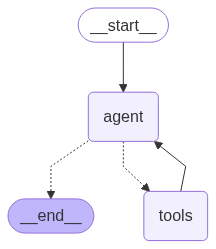

In [ ]:
from  langgraph.graph import START, END
graph_builder = StateGraph(AgentState)
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    ['tools', END]
)
graph_builder.add_edge('tools', 'agent')

graph = graph_builder.compile()

graph